In [7]:
import tensorflow as tf
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import pathlib


Bat_Computer = True
if(Bat_Computer):
    projects_path = '/home/ibrahim/Projects/Self_Maneuvering_UGV/'

else:
    projects_path = '/home/ibrahim/Projects/Self_Maneuvering_UGV/'


images_path = '/home/ibrahim/Projects/Datasets/Ch2_001/center/'
csv_path    = '/home/ibrahim/Projects/Datasets/Ch2_001/final_example.csv'

In [8]:
csv_file = pd.read_csv(csv_path)
csv_file['frame_id'] = csv_file['frame_id'].astype(str)
print(csv_file.head(3))

image_names =  images_path +  csv_file['frame_id'] + '.jpg'
steering_angles = csv_file['steering_angle']
print(image_names[0])
print(steering_angles[0])


              frame_id  steering_angle
0  1479425441182877835       -0.373665
1  1479425441232704425       -0.065396
2  1479425441282730750       -0.160735
/home/ibrahim/Projects/Datasets/Ch2_001/center/1479425441182877835.jpg
-0.37366510611027504


In [9]:
steering_angles.shape

(5614,)

In [10]:
# Not Using prefetching here && TF sucks !!

dataset = tf.data.Dataset.from_tensor_slices((image_names,steering_angles))

def load_images(filename, target):
    img = tf.io.read_file(filename)
    print(img)
    img = tf.image.decode_jpeg(img, channels=3)
    # img = img[150:][150:]
    # img = img.numpy()

    return img, target

def image_augmentations(image, label):
    # Change to grayscale:
    image = tf.image.rgb_to_grayscale(image)
    return image, label

# Note: DO NOT USE MAPPING FOR ANY OTHER CHILD SETS CREATED

dataset = (
  dataset
  .map(load_images)
  .map(image_augmentations)
  .shuffle(1000)
)

for image, label in dataset.take(50):
  # print("Image shape: ", image.numpy().shape)
  # print("Label: ", label.numpy())
  image = image.numpy()
  cv2.imshow('frame',image)
  cv2.waitKey(100)
  
cv2.destroyAllWindows()


Tensor("ReadFile:0", shape=(), dtype=string)


In [11]:
# Improve input pipeline performance by using prefetching etc

train_ds = dataset
batch_size = 10 #change according to hardware auqat
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)


def configure_for_performance(ds):
  ds = ds.cache()
#   ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


train_ds = configure_for_performance(train_ds)



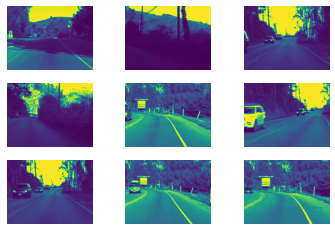

In [12]:
image_batch, label_batch = next(iter(train_ds))

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
#   plt.title(class_names[label])
  plt.axis("off")

